In [1]:
# Поиск пачек
# Лрокализация пачек спайков
def find_brusts(firings_t, Tmax):
    # интенсивность спайковой активности на электроде
    fc = len(firings_t)/Tmax
    # определние порогового времени для малого пачечного события
    tau_c = min(2/(fc), 100)
    #print(tau_c)
    brusts = []
    brust = [firings_t[0]]
    for t in firings_t[1:]:
        if abs(t-brust[-1]) <= tau_c:
            brust.append(t)
        else:
            brusts.append(brust)
            brust=[t]
    brusts.append(brust)
    return brusts

def determ_spikes(firings_t, firings_n, N):
    firings=[]
    for n in range(N):
        firing = []
        for i in range(len(firings_t)):
            if firings_n[i] == n:
                firing.append(firings_t[i])
        
        firings.append(firing)
    return firings
    
def draw_brusts(brusts):
    #plt.figure(figsize=(15, 5))
    for x in brusts:
        plt.axvline(x = min(x), ymin=0, ymax=1, color='red')
        plt.axvline(x = max(x), ymin=0, ymax=1, color='blue')
    #plt.plot(T, v)
    return None

# Характеристики пачек
def get_brusts_duration(brusts):
    brusts = np.array(brusts)
    durations = []
    for brust in brusts:
        duration = np.max(brust) - np.min(brust)
        durations.append(duration)
    durations_mean = np.mean(durations)
    durations_std = np.std(durations)
    return(durations_mean, durations_std)

def get_brust_frequency(brusts):
    brusts = np.array(brusts)
    freqs = np.array([])
    for brust in brusts:
        brust = np.array(brust)
        #print(brust)
        f = 1/(brust[1:] - brust[:-1])*1000
        #print(f)
        freqs = np.concatenate((freqs, f))
    freqs_mean = np.mean(freqs)
    freqs_std = np.std(freqs)
    return (freqs_mean, freqs_std)

In [2]:
# inport libs and create network links
from brian2 import *
import numpy as np
from displayers import visualise_connectivity, draw_sym
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
import warnings
import pandas as pd
warnings.filterwarnings('ignore')

eqs_IJIK = '''
    dv/dt = (0.04*v**2 + 5*v + 140 - u + I + Isyn)/(ms) : 1
    du/dt = a*(b*v-u)/ms : 1
    dIsyn/dt = -Isyn/tau: 1
    a : 1
    b : 1
    c : 1
    d : 1
    I : 1
    tau : second
'''
# Interconnections
Interlinks = np.array([
    [0, -0.3, 0, 0, 0, 0],
    [0, 0, 1, 1, 0, 2],
    [0, 0, 0, 0, 0, -0.6],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, -0.6],
    [0, 0, 0, 0, 1, 0]
])

Externlinks = np.array([
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0], # deleted CPG-N ingibitory synaps
    [0, 0, -0.5, 0, 0, 0],
    [2, 0, 0, -0.5, 0, -0.3],
    [0, 0, 0, 0, -0.5, 0],
    [0, 0, 0, 0, 0, -0.5]
    
])


N = 12
step = int(N/2)
# Create matrix for all the network
Links = np.zeros((N, N), dtype=float)
def add_in_place(target, syllable, x=None, y=None):
    target[y:y+syllable.shape[0], x:x+syllable.shape[1]] += syllable
    return target
    
Links = add_in_place(Links, Interlinks, x=0, y=0)
Links = add_in_place(Links, Interlinks, x=6, y=6)
Links = add_in_place(Links, Externlinks, x=6, y=0)
Links = add_in_place(Links, Externlinks, x=0, y=6)
#print(links)
links = np.asarray(Links).reshape(-1)

WARNING    /home/nickolai/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
 [py.warnings]


In [29]:
def Network(params0, params1, tau):
    start_scope()
    # Creating NeuroGroup modeling the network
    NMS=NeuronGroup(N, eqs_IJIK, threshold = 'v>30',reset="v=c;u=u+d", method='euler')
    NMS.a = 0.02; NMS.b = 0.2; NMS.c = -65; NMS.d = 8; NMS.v = NMS.c; NMS.tau = tau*ms
    #CPG tools
    NMS.a[0] = NMS.a[0+step] = params0['a'];
    NMS.b[0] = NMS.b[0+step] = params0['b'];
    NMS.c[0] = NMS.c[0+step] = params0['c'];
    NMS.d[0] = NMS.d[0+step] = params0['d'];
    NMS.a[1] = NMS.a[1+step] = params1['a'];
    NMS.b[1] = NMS.b[1+step] = params1['b'];
    NMS.c[1] = NMS.c[1+step] = params1['c'];
    NMS.d[1] = NMS.d[1+step] = params1['d'];
    NMS.tau[1] = NMS.tau[1+step] = tau*ms;
    NMS.a[4] = NMS.a[4+step] = params0['a'];
    NMS.b[4] = NMS.b[4+step] = params0['b'];
    NMS.c[4] = NMS.c[4+step] = params0['c'];
    NMS.d[4] = NMS.d[4+step] = params0['d'];
    #Network tools
    Amp = params0['I']
    ampl = params1['I']
    #NMS.I[0] = NMS.I[0+step] = Amp;
    NMS.I[1] = NMS.I[1+step] = ampl;
    # Creating synapses
    NMS_syn = Synapses(NMS, NMS, "w:1", on_pre="Isyn_post -= w*v_pre", delay=0.2*ms)
    NMS_syn.connect()
    NMS_syn.w=links*0.1
    #fig = visualise_connectivity(NMS_syn, r"$NMS \rightarrow NMS$ links")
    #fig.savefig("links.svg")
    ##Simulation

    T = 1*second
    minV = 5
    ## частота входного импульса
    nu = params0['nu']
    a1 = 4; b1 = 3
    alpha = 0.1
    TT = []
    #TTe = []
    le = np.sqrt(a1**2+b1**2)
    lf = np.sqrt(a1**2+b1**2)
    Lf = [lf]
    Le = [le]
    @network_operation(dt=1*ms)
    def change_I0(t):
        NMS.I[0] = Amp*((sin(t*nu*Hz-np.pi/4))>0.1)
        NMS.I[0+step] = Amp*((sin(t*nu*Hz-np.pi/4))<-0.1)
        if NMS.v[5] > -1:
            dlf = -alpha*NMS.v[5];
            le = np.sqrt(2*(a1**2+b1**2)-Lf[-1]**2)
            Lf.append(Lf[-1]+dlf)
            Le.append(le)
            TT.append(t/ms)
        if NMS.v[11] > -1:
            dle = -alpha*NMS.v[11];
            lf = np.sqrt(2*(a1**2+b1**2)-Le[-1]**2)
            Lf.append(lf)
            Le.append(Le[-1]+dle)
            TT.append(t/ms)
        
    NMS_monitor = StateMonitor(NMS, ['u', 'v', 'I', 'Isyn'], record=True)
    Spikes = SpikeMonitor(NMS)
    run(T)
    Spikes_t = np.array(Spikes.t)
    Spikes_i = np.array(Spikes.i)
    Spikes = (Spikes_t, Spikes_i)
    plt.plot(TT, Le[1:], label="Le")
    plt.plot(TT, Lf[1:], label="Lf")
    #plt.ylim([4, 6])
    plt.legend()
    plt.show()
    #print(Le, Lf)
    #print(TT)
    return Spikes_t, Spikes_i, NMS_monitor


#Spikes = Network(params0, params1)

#print(Spikes)
#plot(Spikes[0], Spikes[1], ".k")
#xlabel('Time (ms)')
#ylabel('Neuron index');
#title("Растр активности")
#show()

In [30]:
var_a = pd.DataFrame(columns=["a", "t", "n"])
var_b = pd.DataFrame(columns=["b", "t", "n"])
var_c = pd.DataFrame(columns=["c", "t", "n"])
var_d = pd.DataFrame(columns=["d", "t", "n"])
var_I = pd.DataFrame(columns=["I", "t", "n"])
params0 ={
    'a':0.1, 'b':0.2, 'c':-65, 'd':8, 'I':7.5, 'nu':10
}
params1 ={
    'a':0.02, 'b':0.2, 'c':-65, 'd':8, 'I':5
}


In [31]:
#vars a for CPG-In neuron
#A = np.linspace(0.106, 0.109, 10)
#for a1 in A:
#    params0['a'] = a1
#    var_a.loc[len(var_a)]= [a1, Network(params0, params1)[0], Network(params0, params1)[1]]
#var_a.head(3)

In [32]:
# Построим растры активности сети для каждого а
#plt.figure(figsize=(8, len(A)*4))
#for i in range(len(A)):
#    plt.subplot(len(A)+1, 1, i+1)
#    plt.plot(var_a['t'][i], var_a['n'][i], "k.")
#    plt.title(f"a = {var_a['a'][i]}")
#plt.show()

In [36]:
#vars I for CPG-N neuron

#II = np.linspace(2, 15, 10)
#for i in II:
#    params0['I'] = i
#    var_I.loc[len(var_I)]= [i, Network(params0, params1)[0], Network(params0, params1)[1]]
#var_I.head(3)
#var_I = pd.DataFrame(columns=["I", "t", "n"])


In [37]:
#plt.plot(var_a['t'][9], var_a['n'][9], 'k.')
#show()
#plt.plot(var_b['t'][0], var_b['n'][0], 'k.')
#show()
#plt.plot(var_c['t'][0], var_c['n'][0], 'k.')
#show()
#plt.plot(var_d['t'][0], var_d['n'][0], 'k.')
#show()
#plt.plot(var_I['t'][7], var_I['n'][7], 'k.')
#plt.show()

In [48]:
from ipywidgets import interact
def var(a, c, d, I, t, amp):
    params0["a"] = a;
    params0["I"] = I;
    params0['c'] = c
    params0['d'] = d;
    params1['I'] = amp
    Spikes = Network(params0, params1, t)
    Mon = Spikes[2]
    # find brusts for any neuron
    st = Spikes[0]
    sn = Spikes[1]
    spike_list = []
    spike = []
    
    plt.plot(Spikes[0], Spikes[1], "k.")
    #brusts = find_brusts(Spikes[0], 1000)
    firings=determ_spikes(Spikes[0], Spikes[1], 12)
    #print(firings[0])
    brusts = find_brusts(firings[0], 1000)
    #print(brusts)
    draw_brusts(brusts)
    
    plt.title("Растр активности")
    plt.ylabel("N")
    plt.xlabel("t, ms")
    show()
    fig=figure(figsize=(12, 9))
    fig.suptitle(r"$\tau$ = "+str(np.round(t, 2))+"ms")
    subplot(221)
    plt.title(rf"$CPG-In$ a={np.round(a, 2)}, b=0.2, c={c}, d={d}, I={I}")
    plt.plot(Mon.t/ms, Mon.v[0], label='flex')
    plt.plot(Mon.t/ms, Mon.v[0+step], label='ext')
    plt.ylabel('v')
    plt.xlabel("t, ms")
    legend()
    subplot(222)
    plt.title(rf"$CPG-N$ a=0.02, b=0.2, c=-65, d=8, I = {amp}")
    plt.plot(Mon.t/ms, Mon.v[1], label='flex')
    plt.plot(Mon.t/ms, Mon.v[1+step], label='ext')
    plt.ylabel("v")
    plt.xlabel("t, ms")
    plt.legend()
    subplot(223)
    plt.title("Динамика синаптичечего тока")
    plt.plot(Mon.t/ms, Mon.Isyn[1], label='CPG-N-flex')
    plt.plot(Mon.t/ms, Mon.Isyn[1+step], label='CPG-N-ext')
    plt.ylabel("I_syn")
    plt.xlabel("t, ms")
    legend()
    plt.subplot(2, 2, 4)
    plt.title(rf"$\alpha$-neuron a=0.02, b=0.2, c=-65, d=4")
    plt.plot(Mon.t/ms, Mon.v[5], label='flex')
    plt.plot(Mon.t/ms, Mon.v[5+step], label='ext')
    plt.ylabel("v")
    plt.xlabel("t, ms")
    plt.legend()
    plt.show()
    return None

In [49]:
interact(var, a=(0.02, 0.2, 0.02), c=(-65, -50, 2), I=(7, 10, 0.5), d=(2, 8, 2),t=(0.5, 10, 0.5), amp = (0, 10))

interactive(children=(FloatSlider(value=0.1, description='a', max=0.2, min=0.02, step=0.02), IntSlider(value=-…

<function __main__.var(a, c, d, I, t, amp)>

WARNING    'tau' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value 10. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


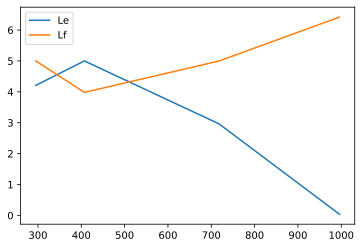

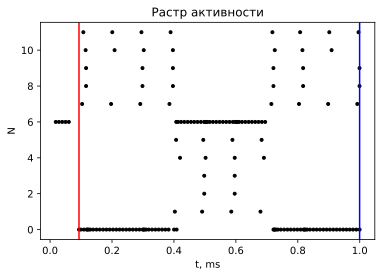

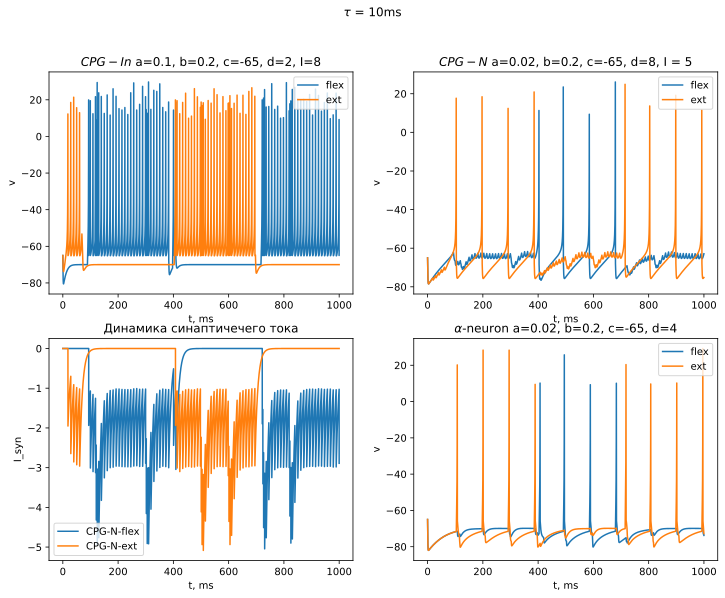

In [51]:
var(0.1, -65, 2, 8, 10, 5)